# Parameter estimation
Tailored to work with the data produced after running the following notbooks:
* Simulate_QRAGE_with_MRZERO.ipynb
* preprocessing_simulated_data.ipynb
* reconstruction_simulated_data.ipynb

In [ ]:
# check for dependencies
import importlib.util

packages = ['joblib', 'git']
for package in packages:
    spec = importlib.util.find_spec(package)
    if (spec==None):
        print('Need to isntall package {}.'.format(package))
        if package=='joblib':
            %pip install joblib
        elif package=='git':
            %pip install gitpython

In [2]:
import os
import git

# clone qrage, if not present
if( not os.path.isdir('../qrage') ):
    print('qrage not installed, cloning ...')
    git.Git('../').clone('https://jugit.fz-juelich.de/inm-4/mr/qrage.git')

# clone parameter estimation, if not present
if( not os.path.isdir('../parameter-estimation') ):
    print('parameter-estimation not installed, cloning ...')
    git.Git('../').clone('https://jugit.fz-juelich.de/inm-4/mr/parameter-estimation.git')

In [ ]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import sys

sys.path.insert(0, "../src")
sys.path.insert(0, '../qrage')
sys.path.insert(0, '../parameter-estimation')

from qrage.sequence.qrage import QRAGE

import h5py

import matplotlib.pyplot as plt
import numpy as np
import pypulseq as pp

from types import SimpleNamespace
from scipy.ndimage import binary_fill_holes

from juart.vis import MultiPlotter

from parest.relaxometry.lm2d import lm_2D_VP

## Load Sequence Parameter
This should be replaced in the future. Here I just copied the definition of the QRAGE sequence from "Simulate_QRAGE_with_MRZERO.ipynb". Maybe the original notebook can store seqeunce parameters into an hdf5 file. I think that it is not feasible?easy to read timing data back from the 

In [4]:
# We need to recreate the qrage sequence with identical parameters to recover the timing
seq = pp.Sequence()

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=20e-6,
    grad_raster_time=50*1e-6
)

num_spokes = 8
num_sets = 19
num_echoes = 9
num_partitions_per_block = 16
num_autocalibration_lines = 32
acceleration_factor = 1
fov = np.array([256, 256, 16]) * 1e-3
matrix_size = np.array([256, 256, 16])
readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [5]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "QRAGE")

In [6]:
qrage = QRAGE(
    system,
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_sets,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    adiabatic_pulse_type="hypsec_n",
    adiabatic_pulse_overdrive=2.0,
    debug=False
)

/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/inversion.py:46: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  self.rf180 = make_adiabatic_pulse(
/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/readout.py:94: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  pp.make_sinc_pulse(
/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/readout.py:129: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  self.adc = pp.make_adc(


In [7]:
qrage.run(seq)

In [8]:
qrage.get_timing(seq)
print(
    "TR %s ms" % np.round(qrage.TR, decimals=1),
    "dTI %s ms" % np.round(qrage.dTI, decimals=1),
    "TI0 %s ms" % np.round(qrage.TI0, decimals=1),
    "dTE %s ms" % np.round(qrage.dTE, decimals=1),
    "TE0 %s ms" % np.round(qrage.TE0, decimals=1),
)

TR 9682.6 ms dTI 508.8 ms TI0 249.8 ms dTE 3.0 ms TE0 3.2 ms


## Load Reonstructed Image

In [9]:
nUS = 8
iS = 1

In [10]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_image_fname =  os.path.join(filepath, 'LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [11]:
with h5py.File(h5_image_fname, "r", libver="latest", swmr=True) as h5_image_file:
    z_image = h5_image_file["x"][...]

## Parameter Estimation
Copied from "Read_Signals.ipynb" under "SimulationStudies/ME_MPNRAGE". 

In [12]:
# Set additional parameters
nTI = num_sets
dTI = qrage.dTI
TI0 =qrage.TI0
nTE = num_echoes
dTE = qrage.dTE
TE0 = qrage.TE0
FA = 5                   # This is currently fixed int the qrage sequence

In [13]:
print('Number of inversions = {}'.format(nTI))
print('Inversion time TI0 = {}'.format(TI0))
print('Delta inversion time DTI = {}'.format(dTI))
print('Number of contrasts = {}'.format(nTE))
print('Echo time TE0 = {}'.format(TE0))
print('Delta echo time DTE = {}'.format(dTE))
print('Excitation flip ange FA = {}'.format(FA))

Number of inversions = 19
Inversion time TI0 = 249.7850000000003
Delta inversion time DTI = 508.80000000000075
Number of contrasts = 9
Echo time TE0 = 3.25
Delta echo time DTE = 2.950000000000003
Excitation flip ange FA = 5


In [14]:
# Magic angle
alpha = np.deg2rad(FA)

In [19]:
# Create mask by thresholding
mask = np.mean(np.abs(z_image), axis=(-2, -1)) > 0.5 * np.max(z_image)

In [20]:
# fill potential holes in the mask
mask = binary_fill_holes(np.squeeze(mask))
mask = mask[:,:,np.newaxis,np.newaxis]

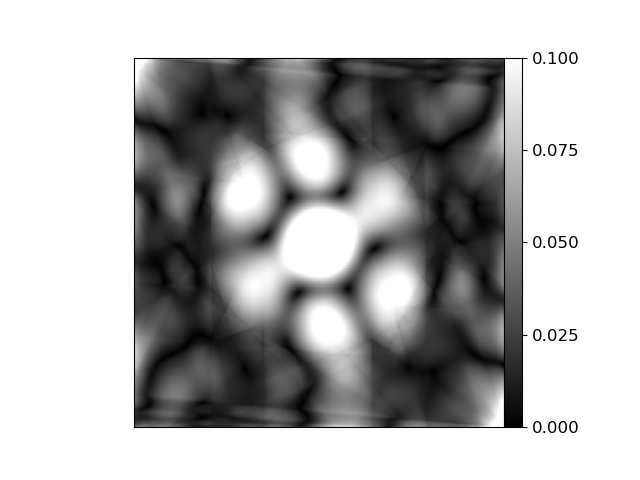

In [21]:
MultiPlotter(np.abs(z_image)[:,:,:,:,0,0], (1,1), axis=(2, 3), vmin=0, vmax=0.1, fig=plt.figure(), cbar=True, cmap='gray')

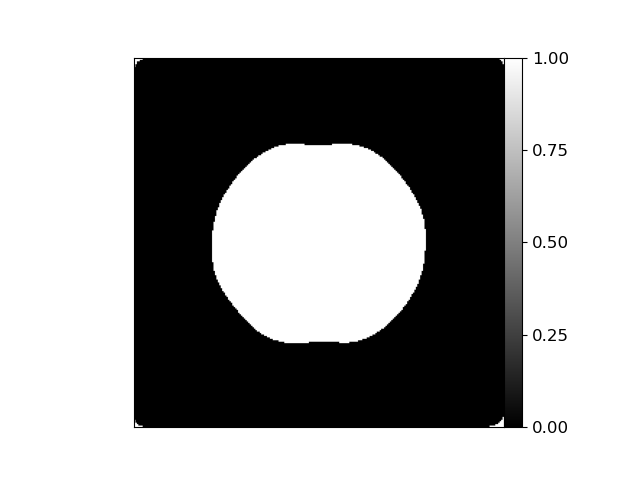

In [22]:
# MultiPlotter(np.transpose(mask,(1,0,2,3)), (1,1), axis=(2, 3), vmin=0, vmax=1, fig=plt.figure(), cbar=True, cmap='gray')
MultiPlotter(mask, (1,1), axis=(2, 3), vmin=0, vmax=1, fig=plt.figure(), cbar=True, cmap='gray')

In [23]:
# do the parameter estimation
ti = np.arange(nTI)[:, None] * dTI + TI0
te = np.arange(nTE)[None, :] * dTE + TE0
tr = qrage.TR
m0_est, r1_est, r2_est = lm_2D_VP(z_image[:, :, :, :, :, :], ti, te, tr, constrained=True, s1=1e3, s2=1e1, t1max=1e4, t2max=1e2)

In [24]:
# Create estimations for T1 and T2
R1s = r1_est.real
R2s = r2_est.real
FM = r2_est.imag
MSS = np.abs(m0_est)
# Minv = m2_est
T1s = 1 / R1s
T1s[~np.isfinite(T1s)] = 0  
T2s = 1 / R2s
T2s[~np.isfinite(T2s)] = 0

In [25]:
# Assume constant B1
B1p = 1

In [26]:
# Recreate T1 from T1*
T1est = 1 / (np.squeeze(1/T1s) + np.log( np.cos( np.abs(B1p) * alpha )) / dTI )
T1est = np.expand_dims(T1est, axis=(2,3))

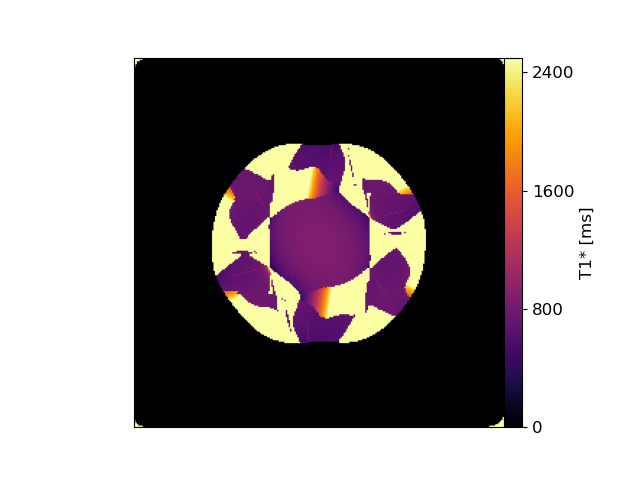

In [28]:
MultiPlotter(T1est * mask, (1, 1), axis=(2,3), vmin=0, vmax=2500, fig=plt.figure(), cmap='inferno', cbar_label='T1* [ms]')

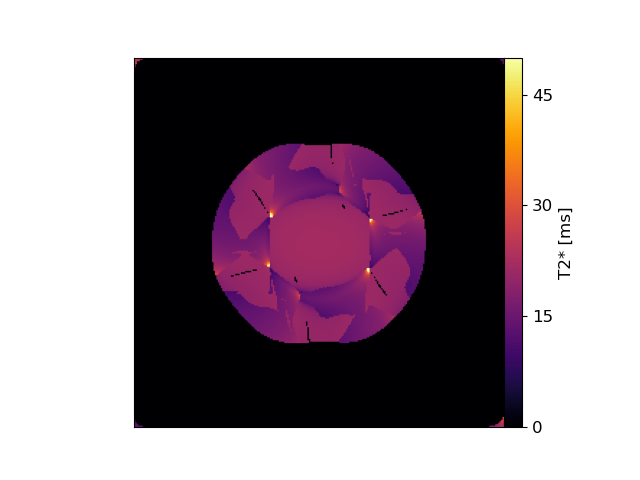

In [29]:
MultiPlotter(T2s * mask, (1, 1), axis=(2, 3), vmin=0, vmax=50, fig=plt.figure(), cmap='inferno', cbar_label='T2* [ms]')